# Evaluation of Graph Neural Network segment classifier

In [23]:
%pwd

'/global/u2/d/danieltm/ExaTrkX/heptrkx-gnn-tracking/notebooks'

In [1]:
# System imports
import os
import sys
import pprint

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [2]:
%matplotlib inline

## Load training results

Specify which results to load either by config file or training output directory.

In [4]:
# Load by config file
config_file = '../configs/agnn_med.yaml'
config = load_config_file(config_file)
summaries = load_summaries(config)

In [3]:
# Load by directory (preferred)
result_base = os.path.expandvars('$SCRATCH/ExaTrkX/doublet_results')

In [4]:
ls $result_base

agnn01/  agnn03/  agnn05/  agnn07/  checkpoints_high/     checkpoints_tiny_000/
agnn02/  agnn04/  agnn06/  agnn08/  checkpoints_med_000/


In [7]:
# result_name = 'checkpoints_high/agnn005'
result_name = 'agnn05'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pprint.pprint(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 4,
          'input_dir': '/global/cscratch1/sd/danieltm/ExaTrkX/doublet_data/hitgraphs_med_002',
          'n_train': 2000,
          'n_valid': 20,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 3.0},
 'model': {'hidden_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_graph_iters': 4,
           'name': 'agnn'},
 'n_ranks': 1,
 'optimizer': {'learning_rate': 0.001,
               'lr_decay_schedule': [{'end_epoch': 20,
                                      'factor': 0.5,
                                      'start_epoch': 10},
                                     {'end_epoch': 40,
                                      'factor': 0.1,
                                      'start_epoch': 20},
                                     {'end_epoch': 50,
                                      'factor': 0.05,
               

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.00100,0.581912,2811.559547,112.164387,0,28.186925,0.492759,0.719118,0.431468
1,0.00100,0.428256,2902.100060,116.434563,1,27.380075,0.460851,0.724541,0.316800
2,0.00100,0.203789,2918.728683,117.462558,2,27.544421,0.153033,0.929213,0.331368
3,0.00100,0.137388,2933.386723,118.098840,3,27.473221,0.126141,0.937527,0.314092
4,0.00100,0.120726,2944.174807,118.565035,4,27.471538,0.147988,0.932430,0.318477
...,...,...,...,...,...,...,...,...,...
59,0.00001,0.055372,3201.313885,132.328846,59,27.396450,0.063699,0.972411,0.318209
60,0.00001,0.055372,3201.492121,132.343407,60,27.550560,0.064348,0.972111,0.318725
61,0.00001,0.055342,3201.659694,132.358268,61,27.609651,0.063386,0.972444,0.319965
62,0.00001,0.055313,3201.824265,132.372864,62,27.618888,0.064356,0.972273,0.322330


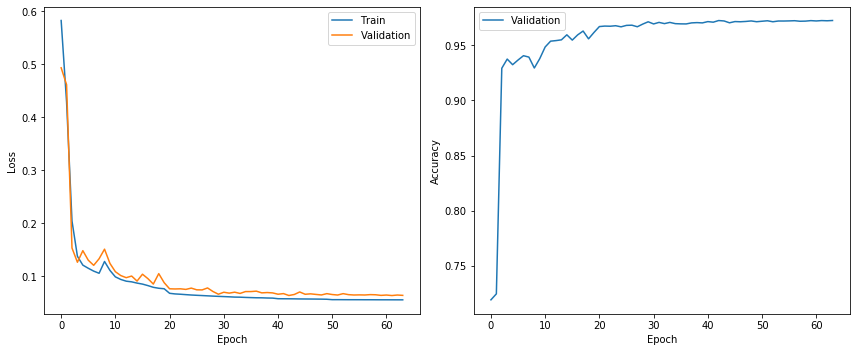

In [8]:
plot_train_history(summaries)

Text(0, 0.5, 'Learning rate')

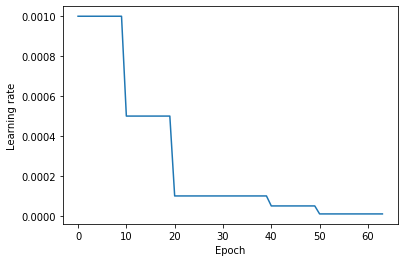

In [9]:
# Plot the learning rate
plt.figure()
plt.plot(summaries.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

## Load the trained model

In [10]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
61,0.00001,0.055342,3201.659694,132.358268,61,27.609651,0.063386,0.972444,0.319965


In [11]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=134, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=201, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    

## Evaluate the model on the test dataset

In [12]:
# Load the test dataset
n_test = 16
test_loader = get_test_data_loader(config, n_test=n_test)

In [13]:
%%time
# Apply the model
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 20.9 s, sys: 85 ms, total: 21 s
Wall time: 6.21 s


In [14]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9737
Precision: 0.8941
Recall:    0.9906


In [15]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9804
Precision: 0.9449
Recall:    0.9615


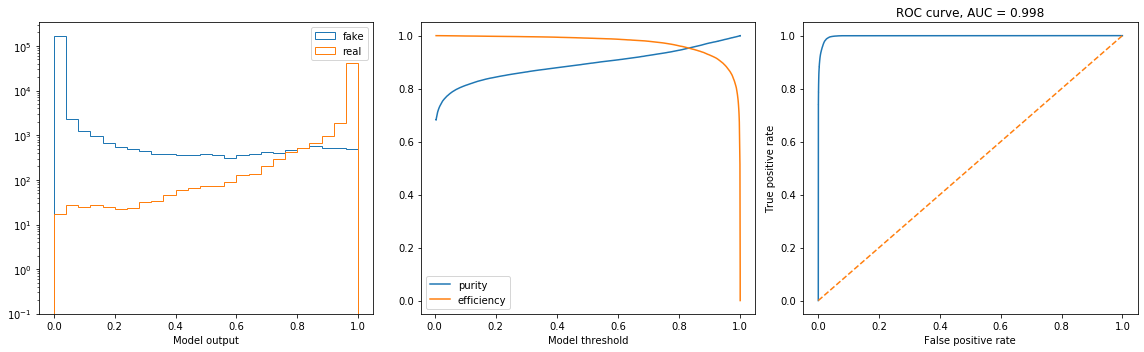

In [16]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [31]:
n_phi_sections = 4
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [34]:
for i in range(n_test):
    g = test_loader.dataset[i]
    e = g.edge_index.numpy()
    x = g.x.numpy() * feature_scale
    y = g.y.numpy()
    o = test_preds[i].numpy()
    print(i, " with edge number: ", len(y), " and hit number: ", len(x))

0  with edge number:  14260  and hit number:  4061
1  with edge number:  14898  and hit number:  4013
2  with edge number:  20671  and hit number:  4990
3  with edge number:  19809  and hit number:  4760
4  with edge number:  12053  and hit number:  3605
5  with edge number:  19458  and hit number:  4680
6  with edge number:  11127  and hit number:  3419
7  with edge number:  9431  and hit number:  3184
8  with edge number:  9725  and hit number:  3241
9  with edge number:  9391  and hit number:  3074
10  with edge number:  18014  and hit number:  4548
11  with edge number:  11176  and hit number:  3489
12  with edge number:  14703  and hit number:  4080
13  with edge number:  13569  and hit number:  3783
14  with edge number:  16057  and hit number:  4258
15  with edge number:  10840  and hit number:  3401


In [16]:
i = 0

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

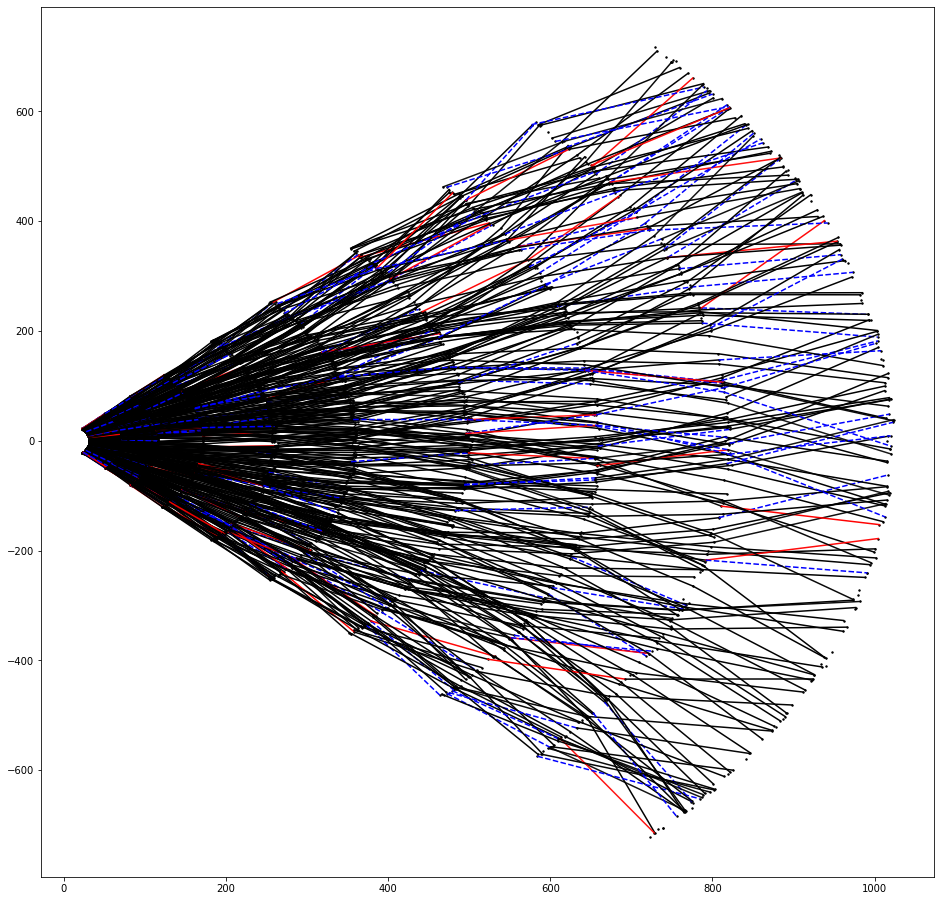

In [17]:
draw_sample_xy(x, e, o, y, cut=0.9);